
# Bayesian Iris Classifier (NumPyro + NUTS)

This notebook replicates a classic Bayesian demonstration using the **Iris** dataset:
- A 1-hidden-layer MLP with **Gaussian priors** over weights and biases
- **Hamiltonian Monte Carlo (NUTS)** to sample from the posterior
- **Posterior predictive** probabilities
- A simple **abstention rule** (“I don’t know”) controlled by a confidence threshold `τ`
- Evaluation with accuracy and **selective prediction** (accuracy vs. coverage)

> Works on Apple Silicon (CPU) out of the box.



## Environment

If you haven't installed the dependencies inside your Pipenv already, run this once in a terminal:

```bash
pipenv run pip install numpyro==0.15.2 jax[cpu]==0.4.28 scikit-learn pandas matplotlib
```


In [1]:

# Imports
import math
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS


In [2]:

# Data: load, split, scale
iris = load_iris()
X = iris.data.astype(np.float32)   # (150, 4)
y = iris.target.astype(np.int32)   # 0..2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y
)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

n_features = X_train.shape[1]
n_hidden   = 8
n_classes  = len(np.unique(y_train))

Xtr = jnp.array(X_train)
Xte = jnp.array(X_test)
ytr = jnp.array(y_train)
yte = jnp.array(y_test)


In [3]:

# Bayesian MLP with Gaussian priors
def relu(x):
    return jnp.maximum(0, x)

def model(X, y=None):
    W1 = numpyro.sample("W1", dist.Normal(0, 1).expand([n_features, n_hidden]).to_event(2))
    b1 = numpyro.sample("b1", dist.Normal(0, 1).expand([n_hidden]).to_event(1))
    W2 = numpyro.sample("W2", dist.Normal(0, 1).expand([n_hidden, n_classes]).to_event(2))
    b2 = numpyro.sample("b2", dist.Normal(0, 1).expand([n_classes]).to_event(1))

    h = relu(jnp.dot(X, W1) + b1)
    logits = jnp.dot(h, W2) + b2

    with numpyro.plate("data", X.shape[0]):
        numpyro.sample("obs", dist.Categorical(logits=logits), obs=y)


In [11]:
nuts = NUTS(model, dense_mass=True, target_accept_prob=0.9, max_tree_depth=12)
mcmc = MCMC(
    nuts,
    num_warmup=1500,      # quick: 800/1000
    num_samples=4000,     # quick: 800/1000
    num_chains=4,         # more chains → better ESS
    chain_method="parallel",
)
mcmc.run(jax.random.PRNGKey(0), X=Xtr, y=ytr)
posterior = mcmc.get_samples()
mcmc.print_summary()      # check ESS and R-hat

/var/folders/gy/rrks26hj5sqf6d7jw7qtnmh00000gn/T/ipykernel_29071/2686628201.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 5500/5500 [00:12<00:00, 440.15it/s, 127 steps of size 3.90e-02. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   W1[0,0]      0.02      0.92      0.05     -1.48      1.54  15067.40      1.00
   W1[0,1]      0.01      0.93      0.05     -1.47      1.59  15873.10      1.00
   W1[0,2]      0.03      0.93      0.06     -1.54      1.52  15462.92      1.00
   W1[0,3]      0.02      0.91      0.05     -1.52      1.48  15047.48      1.00
   W1[0,4]      0.02      0.92      0.04     -1.50      1.53  15591.26      1.00
   W1[0,5]      0.02      0.92      0.05     -1.46      1.55  16190.96      1.00
   W1[0,6]      0.01      0.93      0.03     -1.52      1.53  15859.32      1.00
   W1[0,7]      0.03      0.92      0.06     -1.49      1.51  15126.95      1.00
   W1[1,0]     -0.05      0.94     -0.09     -1.61      1.46  11916.19      1.00
   W1[1,1]     -0.05      0.95     -0.09     -1.53      1.61  12402.30      1.00
   W1[1,2]     -0.06      0.94     -0.10     -1.63      1.44  12290.75      1.00
   W1[1,3]     -0.07      0

In [12]:

# Posterior predictive probabilities
def forward_logits(X, params):
    h = relu(jnp.dot(X, params["W1"]) + params["b1"])
    return jnp.dot(h, params["W2"]) + params["b2"]

def posterior_class_probs(X, posterior_dict):
    # vectorize forward pass over posterior samples
    logits_samples = jax.vmap(lambda p: forward_logits(X, p))(posterior_dict)  # (S, N, C)
    probs_samples = jax.nn.softmax(logits_samples, axis=-1)
    mean_probs = probs_samples.mean(axis=0)  # (N, C)
    return np.asarray(mean_probs)

p_tr = posterior_class_probs(Xtr, posterior)
p_te = posterior_class_probs(Xte, posterior)

yhat_tr = p_tr.argmax(axis=1)
yhat_te = p_te.argmax(axis=1)

acc_tr = accuracy_score(y_train, yhat_tr)
acc_te = accuracy_score(y_test, yhat_te)
acc_tr, acc_te


(0.97, 0.92)

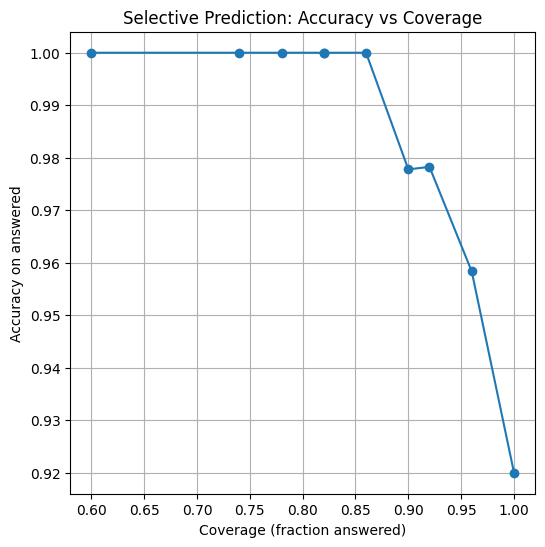

In [53]:

# Selective prediction: abstain below threshold tau
def evaluate_with_abstention(probs, y_true, tau=0.8):
    probs = np.asarray(probs)
    conf = probs.max(axis=1)
    pred = probs.argmax(axis=1)
    answered = conf >= tau
    coverage = answered.mean()
    acc = float("nan") if coverage == 0 else (pred[answered] == y_true[answered]).mean()
    return coverage, acc

taus = np.linspace(0.5, 0.95, 10)
coverages = []
accs = []
for t in taus:
    cov, acc = evaluate_with_abstention(p_te, y_test, tau=float(t))
    coverages.append(cov)
    accs.append(acc)

# Plot: accuracy vs coverage (selective risk curve)
plt.figure(figsize=(6,6))
plt.plot(coverages, accs, marker='o')
plt.xlabel("Coverage (fraction answered)")
plt.ylabel("Accuracy on answered")
plt.title("Selective Prediction: Accuracy vs Coverage")
plt.grid(True)
plt.show()


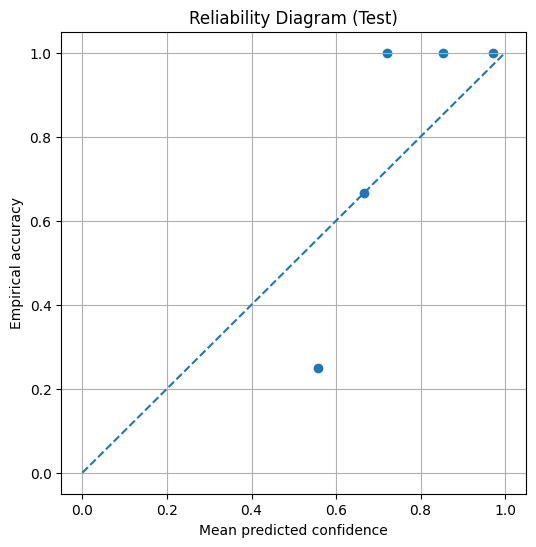

In [14]:

# Reliability diagram (optional): 10-bin calibration
def reliability_curve(probs, y_true, bins=10):
    probs = np.asarray(probs)
    y_true = np.asarray(y_true)
    conf = probs.max(axis=1)
    pred = probs.argmax(axis=1)

    bin_edges = np.linspace(0.0, 1.0, bins + 1)
    bin_ids = np.digitize(conf, bin_edges) - 1
    bin_acc = []
    bin_conf = []
    bin_count = []
    for b in range(bins):
        mask = bin_ids == b
        if mask.sum() > 0:
            bin_acc.append((pred[mask] == y_true[mask]).mean())
            bin_conf.append(conf[mask].mean())
            bin_count.append(mask.sum())
        else:
            bin_acc.append(np.nan)
            bin_conf.append(np.nan)
            bin_count.append(0)
    return np.array(bin_conf), np.array(bin_acc), np.array(bin_count), bin_edges

bin_conf, bin_acc, bin_cnt, edges = reliability_curve(p_te, y_test, bins=10)

plt.figure(figsize=(6,6))
# perfect calibration line
plt.plot([0,1], [0,1], linestyle='--')
# points per bin (skip NaNs)
valid = ~np.isnan(bin_conf)
plt.scatter(bin_conf[valid], bin_acc[valid])
plt.xlabel("Mean predicted confidence")
plt.ylabel("Empirical accuracy")
plt.title("Reliability Diagram (Test)")
plt.grid(True)
plt.show()


In [15]:
# --- Prior vs Posterior (single parameter) ---
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# If you change priors in the model, reflect them here
PRIOR_DEFAULTS = {
    "W1": (0.0, 1.0),
    "b1": (0.0, 1.0),
    "W2": (0.0, 1.0),
    "b2": (0.0, 1.0),
}

def _extract_entry(samples, idx_tuple=None):
    """
    samples: posterior[param_name] array with shape (S, *param_shape)
    idx_tuple: e.g. (0,1) for W1[i,j], (3,) for b1[j]; None flattens all entries
    returns: vector of samples, shape (S,)
    """
    arr = np.asarray(samples)
    if idx_tuple is None:
        return arr.reshape(-1)
    return arr[(slice(None),) + idx_tuple].reshape(-1)

def plot_prior_vs_posterior(posterior_dict, param_name, idx_tuple=None, bins=60, show_ci=True):
    """
    posterior_dict: mcmc.get_samples() output
    param_name: 'W1' | 'b1' | 'W2' | 'b2' (or whatever keys you used)
    idx_tuple: which entry to visualize; if None, flattens all entries together
    """
    if param_name not in posterior_dict:
        raise ValueError(f"{param_name} not in posterior.")
    samples = _extract_entry(posterior_dict[param_name], idx_tuple)
    mu0, sigma0 = PRIOR_DEFAULTS.get(param_name, (0.0, 1.0))

    # Range for drawing prior
    lo, hi = float(np.min(samples)), float(np.max(samples))
    pad = 0.1 * (hi - lo + 1e-6)
    xs = np.linspace(lo - pad, hi + pad, 400)
    prior_pdf = norm.pdf(xs, loc=mu0, scale=sigma0)

    # Plot
    plt.figure(figsize=(7, 4))
    plt.hist(samples, bins=bins, density=True, histtype="step", linewidth=2, label="posterior", color="k")
    plt.plot(xs, prior_pdf, linewidth=2, label="prior", color="gray")

    if show_ci:
        q_lo, q_hi = np.percentile(samples, [2.5, 97.5])
        plt.axvline(q_lo, linestyle="--", linewidth=1, color="k")
        plt.axvline(q_hi, linestyle="--", linewidth=1, color="k")

    title_idx = "" if idx_tuple is None else f"[{', '.join(map(str, idx_tuple))}]"
    plt.title(f"Prior vs Posterior for {param_name}{title_idx}")
    plt.xlabel(f"{param_name}{title_idx}")
    plt.ylabel("density")
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
# --- Batch exporter: save prior vs posterior plots for all tensor entries ---
def save_prior_posterior_fig(
    posterior_dict,
    param_name,
    idx_tuple,
    out_dir="figures/prior_posterior",
    bins=60,
    dpi=140,
):
    os.makedirs(out_dir, exist_ok=True)
    samples = _extract_entry(posterior_dict[param_name], idx_tuple)
    mu0, sigma0 = PRIOR_DEFAULTS.get(param_name, (0.0, 1.0))

    lo, hi = float(np.min(samples)), float(np.max(samples))
    pad = 0.1 * (hi - lo + 1e-6)
    xs = np.linspace(lo - pad, hi + pad, 400)
    prior_pdf = norm.pdf(xs, loc=mu0, scale=sigma0)

    plt.figure(figsize=(7, 4))
    plt.hist(samples, bins=bins, density=True, histtype="step", linewidth=2, label="posterior", color="k")
    plt.plot(xs, prior_pdf, linewidth=2, label="prior", color="gray")
    q_lo, q_hi = np.percentile(samples, [2.5, 97.5])
    plt.axvline(q_lo, linestyle="--", linewidth=1, color="k")
    plt.axvline(q_hi, linestyle="--", linewidth=1, color="k")
    title_idx = f"[{', '.join(map(str, idx_tuple))}]"
    plt.title(f"Prior vs Posterior for {param_name}{title_idx}")
    plt.xlabel(f"{param_name}{title_idx}")
    plt.ylabel("density")
    plt.legend()
    plt.grid(True)

    fname = f"{param_name}_" + "_".join(map(str, idx_tuple)) + ".png"
    out_path = os.path.join(out_dir, fname)
    plt.savefig(out_path, bbox_inches="tight", dpi=dpi)
    plt.close()
    return out_path

def export_all_prior_posterior_plots(
    posterior_dict,
    param_names=("W1", "b1", "W2", "b2"),
    out_dir="figures/prior_posterior",
    bins=60,
    dpi=140,
    limit_per_param=None,
):
    """
    Iterates over all entries of each parameter tensor and saves a PNG per entry.
    - limit_per_param: if set (e.g., 20), caps the number of plots per parameter to avoid huge dumps.
    Returns a dict: {param_name: [list of file paths]}
    """
    exported = {}
    for pname in param_names:
        if pname not in posterior_dict:
            continue
        arr = np.asarray(posterior_dict[pname])
        if arr.ndim < 2:
            # shape (S,) — scalar param → one idx=()
            shape = ()
        else:
            shape = arr.shape[1:]  # drop sample dim
        idx_iter = list(np.ndindex(shape)) if shape != () else [()]

        if (limit_per_param is not None) and (len(idx_iter) > limit_per_param):
            idx_iter = idx_iter[:limit_per_param]

        paths = []
        for idx in idx_iter:
            p = save_prior_posterior_fig(
                posterior_dict,
                param_name=pname,
                idx_tuple=idx if idx != () else None,
                out_dir=out_dir,
                bins=bins,
                dpi=dpi,
            )
            paths.append(p)
        exported[pname] = paths
    return exported

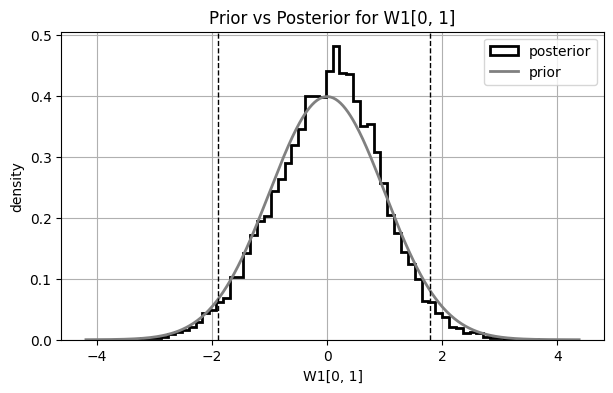

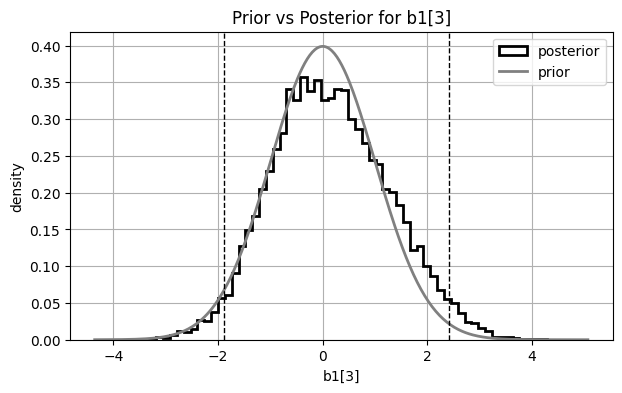

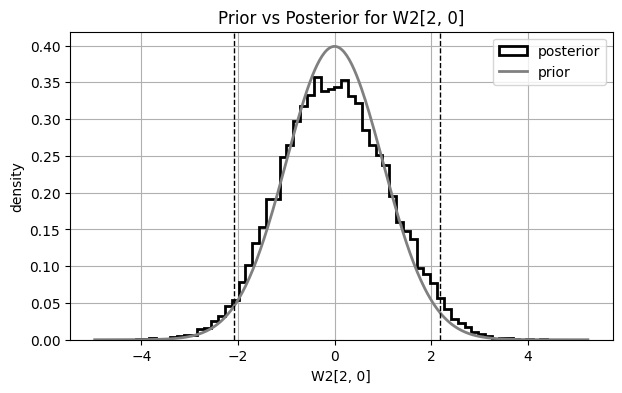

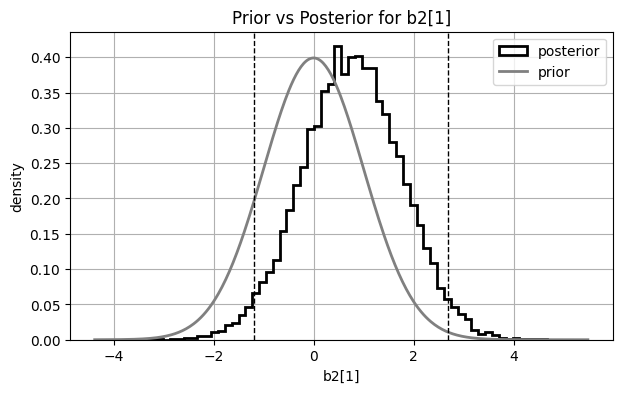

W1 → 32 files (e.g.,) ['figures/prior_posterior/W1_0_0.png', 'figures/prior_posterior/W1_0_1.png', 'figures/prior_posterior/W1_0_2.png']
b1 → 8 files (e.g.,) ['figures/prior_posterior/b1_0.png', 'figures/prior_posterior/b1_1.png', 'figures/prior_posterior/b1_2.png']
W2 → 24 files (e.g.,) ['figures/prior_posterior/W2_0_0.png', 'figures/prior_posterior/W2_0_1.png', 'figures/prior_posterior/W2_0_2.png']
b2 → 3 files (e.g.,) ['figures/prior_posterior/b2_0.png', 'figures/prior_posterior/b2_1.png', 'figures/prior_posterior/b2_2.png']


In [17]:
# After you've run NUTS and 'posterior' exists:

# Single parameter overlays (on-screen)
plot_prior_vs_posterior(posterior, "W1", (0, 1))
plot_prior_vs_posterior(posterior, "b1", (3,))
plot_prior_vs_posterior(posterior, "W2", (2, 0))
plot_prior_vs_posterior(posterior, "b2", (1,))

# Batch export: saves PNGs under figures/prior_posterior/
export_summary = export_all_prior_posterior_plots(
    posterior,
    param_names=("W1", "b1", "W2", "b2"),
    out_dir="figures/prior_posterior",
    bins=60,
    dpi=160,
    limit_per_param=50,  # set None to export all entries
)

# Quick peek at what was saved:
for k, v in export_summary.items():
    print(k, "→", len(v), "files (e.g.,)", v[:3])

In [18]:
# --- 2D marginalized posterior with HDR contours & mode markers ---

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.ndimage import maximum_filter, gaussian_filter

def _extract_entry(samples, idx_tuple=None):
    arr = np.asarray(samples)
    if idx_tuple is None:
        # flatten all params together (rarely what you want in 2D)
        return arr.reshape(-1)
    return arr[(slice(None),) + idx_tuple].reshape(-1)

def _kde_hdr_levels(Z, xs, ys, probs=(0.683, 0.955, 0.997)):
    """
    Given KDE values Z on a (len(ys), len(xs)) grid, compute density thresholds
    s.t. the superlevel set has integrated mass equal to each prob in `probs`.
    """
    # Normalize Z to a probability mass over grid area
    dx = (xs[1] - xs[0]) if len(xs) > 1 else 1.0
    dy = (ys[1] - ys[0]) if len(ys) > 1 else 1.0
    Z_mass = Z / Z.sum()  # since dx*dy constant, it cancels when comparing levels
    z_sorted = np.sort(Z_mass.ravel())[::-1]
    cumsum = np.cumsum(z_sorted)
    levels = []
    for p in probs:
        # find smallest density threshold t such that mass of {Z>=t} >= p
        idx = np.searchsorted(cumsum, p)
        t_mass = z_sorted[idx] if idx < len(z_sorted) else z_sorted[-1]
        # convert back to raw density scale (constant factor cancels anyway)
        levels.append(t_mass * Z.sum())
    return levels

def _local_maxima(Z, min_separation=5, top_k=2):
    """
    Find up to top_k local maxima in Z (2D array). min_separation in pixels.
    """
    # smooth a bit to avoid tiny ripples
    Zs = gaussian_filter(Z, sigma=1.0)
    # rank peaks by value
    cand_mask = (Zs == maximum_filter(Zs, size=3))
    ys, xs = np.where(cand_mask)
    vals = Zs[ys, xs]
    order = np.argsort(vals)[::-1]
    peaks = []
    for i in order:
        y, x = ys[i], xs[i]
        if all((abs(y - py) >= min_separation or abs(x - px) >= min_separation) for (py, px) in peaks):
            peaks.append((y, x))
            if len(peaks) >= top_k:
                break
    return peaks  # list of (y_idx, x_idx)

def plot_posterior_2d(
    posterior,
    x_name, x_idx,
    y_name, y_idx,
    n_grid=200,
    probs=(0.683, 0.955, 0.997),
    cmap_colors=("#4CAF50", "#FFEB3B", "#F44336"),  # green/yellow/red
    scatter_subsample=0,   # e.g., 1000 to overlay samples, 0 to disable
    show_local_mode=True,
    save_path=None,
    title=None,
):
    """
    Make a 2D marginalized posterior plot for parameters:
      x = posterior[x_name][:, ...][..., x_idx]
      y = posterior[y_name][:, ...][..., y_idx]
    """
    xsamp = _extract_entry(posterior[x_name], x_idx)
    ysamp = _extract_entry(posterior[y_name], y_idx)
    data = np.vstack([xsamp, ysamp])

    # KDE over grid
    kde = gaussian_kde(data)
    # grid extent with padding
    x_lo, x_hi = np.percentile(xsamp, [0.5, 99.5])
    y_lo, y_hi = np.percentile(ysamp, [0.5, 99.5])
    pad_x = 0.15 * (x_hi - x_lo + 1e-9)
    pad_y = 0.15 * (y_hi - y_lo + 1e-9)
    xs = np.linspace(x_lo - pad_x, x_hi + pad_x, n_grid)
    ys = np.linspace(y_lo - pad_y, y_hi + pad_y, n_grid)
    XX, YY = np.meshgrid(xs, ys)
    Z = kde(np.vstack([XX.ravel(), YY.ravel()])).reshape(n_grid, n_grid)

    # HDR levels (convert probs to descending for filled contours)
    probs_sorted = sorted(probs)
    levels = _kde_hdr_levels(Z, xs, ys, probs=probs_sorted)

    # Filled contours: smallest region (highest density) in green, then yellow, red
    fig, ax = plt.subplots(figsize=(7, 5.8))
    # We want cumulative fills: region with >= level_i mass (high density)
    # Draw biggest region first so smaller ones overwrite
    for i, (p, lvl) in enumerate(reversed(list(zip(probs_sorted, levels)))):
        color = cmap_colors[i] if i < len(cmap_colors) else None
        ax.contourf(XX, YY, Z, levels=[lvl, Z.max()*1.01], colors=[color], alpha=0.85)

    # Optional sample scatter for intuition
    if scatter_subsample and scatter_subsample > 0:
        idx = np.random.choice(len(xsamp), size=min(scatter_subsample, len(xsamp)), replace=False)
        ax.plot(xsamp[idx], ysamp[idx], "k.", ms=2, alpha=0.2)

    # Global and (optional) local mode(s)
    peaks = _local_maxima(Z, min_separation=max(3, n_grid // 40), top_k=2 if show_local_mode else 1)
    if len(peaks) >= 1:
        gy, gx = peaks[0]
        ax.plot(xs[gx], ys[gy], "o", mfc="white", mec="k", ms=7, label="global mode")
    if show_local_mode and len(peaks) >= 2:
        ly, lx = peaks[1]
        ax.plot(xs[lx], ys[ly], "s", mfc="white", mec="k", ms=6, label="local mode")

    # Posterior mean & std crosshair
    mx, my = xsamp.mean(), ysamp.mean()
    sx, sy = xsamp.std(ddof=1), ysamp.std(ddof=1)
    ax.plot([mx - sx, mx + sx], [my, my], "-", color="k", lw=2)
    ax.plot([mx, mx], [my - sy, my + sy], "-", color="k", lw=2)
    ax.plot(mx, my, "ko", ms=4, label="mean ± std")

    # Legend patches to match fills
    patches = [
        Patch(facecolor=cmap_colors[0], label="smallest 68.3% interval(s)"),
        Patch(facecolor=cmap_colors[1], label="smallest 95.5% interval(s)"),
        Patch(facecolor=cmap_colors[2], label="smallest 99.7% interval(s)"),
    ]
    lines = [
        Line2D([], [], marker="o", color="k", mfc="white", linestyle="None", label="global mode"),
        Line2D([], [], marker="s", color="k", mfc="white", linestyle="None", label="local mode"),
        Line2D([], [], marker="o", color="k", linestyle="-", label="mean and std. dev."),
    ]
    leg_items = patches + lines[: (2 if show_local_mode else 1)] + [lines[-1]]
    ax.legend(handles=leg_items, loc="upper right", framealpha=0.9)

    # Labels & styling
    xtxt = f"{x_name}[{', '.join(map(str, x_idx))}]" if x_idx is not None else x_name
    ytxt = f"{y_name}[{', '.join(map(str, y_idx))}]" if y_idx is not None else y_name
    ax.set_xlabel(xtxt)
    ax.set_ylabel(ytxt)
    if title is None:
        ax.set_title(f"2D Posterior: {ytxt} vs {xtxt}")
    else:
        ax.set_title(title)
    ax.grid(True, alpha=0.25)

    if save_path:
        fig.savefig(save_path, dpi=180, bbox_inches="tight")
        plt.close(fig)
        return save_path
    else:
        plt.show()
        return None

In [19]:
# --- Run 2D marginalized posterior plots for multiple pairs ---

import os
import numpy as np
from itertools import product

OUT_DIR = "figures/posterior2d"
os.makedirs(OUT_DIR, exist_ok=True)

def _shape_without_samples(arr):
    arr = np.asarray(arr)
    return arr.shape[1:] if arr.ndim >= 2 else ()

def _all_indices(shape):
    return [()] if shape == () else list(np.ndindex(shape))

def run_2d_pairs(
    posterior,
    pairs,
    n_grid=220,
    scatter_subsample=0,
    show_local_mode=True,
    prefix="pair",
):
    """
    pairs: list of tuples like
        (x_name, x_idx_tuple, y_name, y_idx_tuple)
      e.g.: ("W1", (0,2), "W2", (3,1))
    Saves PNGs to OUT_DIR and returns list of paths.
    """
    saved = []
    for i, (xn, xi, yn, yi) in enumerate(pairs, start=1):
        fname = f"{prefix}_{xn}_{'_'.join(map(str, xi)) if xi is not None else 'all'}__{yn}_{'_'.join(map(str, yi)) if yi is not None else 'all'}.png"
        save_path = os.path.join(OUT_DIR, fname)
        plot_posterior_2d(
            posterior,
            x_name=xn, x_idx=xi,
            y_name=yn, y_idx=yi,
            n_grid=n_grid,
            scatter_subsample=scatter_subsample,
            show_local_mode=show_local_mode,
            save_path=save_path,
        )
        saved.append(save_path)
    return saved

# -------- OPTIONAL: auto-suggest interesting pairs by correlation --------
def suggest_pairs_by_corr(posterior, x_name, y_name, top_k=5, rng_seed=0):
    """
    Finds top_k index pairs with highest |corr| between entries of x_name and y_name.
    Returns a list of (x_name, x_idx, y_name, y_idx).
    """
    rng = np.random.default_rng(rng_seed)
    X = np.asarray(posterior[x_name])   # (S, ...shape_x)
    Y = np.asarray(posterior[y_name])   # (S, ...shape_y)

    shape_x, shape_y = _shape_without_samples(X), _shape_without_samples(Y)
    idxs_x, idxs_y = _all_indices(shape_x), _all_indices(shape_y)

    # to keep it fast, subsample candidate indices if very large
    cap = 100
    if len(idxs_x) > cap:
        idxs_x = list(rng.choice(idxs_x, size=cap, replace=False))
    if len(idxs_y) > cap:
        idxs_y = list(rng.choice(idxs_y, size=cap, replace=False))

    cands = []
    for ix in idxs_x:
        xs = X[(slice(None),) + ix].reshape(-1)
        xs = (xs - xs.mean()) / (xs.std(ddof=1) + 1e-9)
        for iy in idxs_y:
            ys = Y[(slice(None),) + iy].reshape(-1)
            ys = (ys - ys.mean()) / (ys.std(ddof=1) + 1e-9)
            corr = float(np.clip(np.corrcoef(xs, ys)[0,1], -1, 1))
            cands.append((abs(corr), (x_name, ix, y_name, iy)))
    cands.sort(key=lambda t: t[0], reverse=True)
    return [c for _, c in cands[:top_k]]

# ------------------- EXAMPLES -------------------

# 1) Manual selection of pairs you care about:
manual_pairs = [
    ("W1", (0,2), "W2", (0,0)),
    ("W1", (1,3), "W2", (2,1)),
    ("b1", (2,),   "W2", (3,1)),
    ("b1", (0,),   "b2", (1,)),
]

saved_paths = run_2d_pairs(
    posterior,
    manual_pairs,
    n_grid=220,
    scatter_subsample=800,   # set 0 to disable overlay of raw samples
    show_local_mode=True,
    prefix="manual",
)
print("Saved (manual):", *saved_paths, sep="\n  ")

# 2) Auto-suggest top correlated pairs between two tensors (e.g., W1 vs W2)
auto_pairs = suggest_pairs_by_corr(posterior, "W1", "W2", top_k=6)
saved_auto = run_2d_pairs(
    posterior,
    auto_pairs,
    n_grid=220,
    scatter_subsample=800,
    show_local_mode=True,
    prefix="auto_corr_W1_W2",
)
print("Saved (auto):", *saved_auto, sep="\n  ")

Saved (manual):
  figures/posterior2d/manual_W1_0_2__W2_0_0.png
  figures/posterior2d/manual_W1_1_3__W2_2_1.png
  figures/posterior2d/manual_b1_2__W2_3_1.png
  figures/posterior2d/manual_b1_0__b2_1.png
Saved (auto):
  figures/posterior2d/auto_corr_W1_W2_W1_3_3__W2_3_2.png
  figures/posterior2d/auto_corr_W1_W2_W1_3_2__W2_2_2.png
  figures/posterior2d/auto_corr_W1_W2_W1_3_7__W2_7_2.png
  figures/posterior2d/auto_corr_W1_W2_W1_3_4__W2_4_2.png
  figures/posterior2d/auto_corr_W1_W2_W1_3_0__W2_0_2.png
  figures/posterior2d/auto_corr_W1_W2_W1_3_6__W2_6_2.png


In [46]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def classify_with_uncertainty_sigma(
    posterior, X_event, entry_id=None, y_true=None, class_names=None, n_draws=None
):
    """
    Posterior predictive classification with mean ± 1σ error bars.
    Legend shows:
      - black circles = Posterior (mean ± 1σ)
      - blue circle   = predicted class (argmax of posterior mean)
      - red star      = true class (if provided)
    """
    if X_event.ndim == 1:
        X_event = X_event[None, :]

    def forward_logits(params):
        h = np.maximum(0, np.dot(X_event, params["W1"]) + params["b1"])
        return np.dot(h, params["W2"]) + params["b2"]

    # Gather posterior draws
    samples = list(zip(
        posterior["W1"], posterior["b1"], posterior["W2"], posterior["b2"]
    ))
    if n_draws:
        idx = np.random.choice(len(samples), size=n_draws, replace=False)
        samples = [samples[i] for i in idx]

    probs = []
    for W1, b1, W2, b2 in samples:
        params = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
        logits = forward_logits(params)
        p = np.exp(logits - logits.max())
        p = p / p.sum()
        probs.append(p.squeeze())
    probs = np.array(probs)

    mean = probs.mean(axis=0)
    std = probs.std(axis=0)
    y_pred = int(mean.argmax())

    n_classes = probs.shape[1]
    xs = np.arange(n_classes)
    labels = list(class_names) if class_names is not None else list(map(str, xs))

    # error bars only
    plt.errorbar(xs, mean, yerr=std, fmt="none", ecolor="k", capsize=5)
    # black dots = posterior mean
    plt.plot(xs, mean, "o", color="k", markersize=6)

    # predicted = blue dot
    plt.plot(xs[y_pred], mean[y_pred], "o", color="blue", markersize=10)

    # true = red star
    if y_true is not None:
        plt.plot(xs[y_true], mean[y_true], marker="*", color="red", markersize=14)

    plt.xticks(xs, labels)
    plt.ylabel("Probability")
    plt.xlabel("Category")
    plt.ylim(0, 1)

    # Title: Posterior for entry N
    entry_text = f" {entry_id}" if entry_id is not None else ""
    plt.title(f"Posterior for entry{entry_text}")

    # Legend
    legend_elements = [
        Line2D([0], [0], marker="o", color="k", linestyle="none", markersize=6,
               label="Posterior (mean ± 1σ)"),
        Line2D([0], [0], marker="o", color="blue", linestyle="none", markersize=10,
               label="Predicted"),
        Line2D([0], [0], marker="*", color="red", linestyle="none", markersize=14,
               label="True"),
    ]
    plt.legend(handles=legend_elements, loc="best")

    plt.grid(alpha=0.3)
    plt.show()

    return mean, std, y_pred

Event 0, true label = virginica


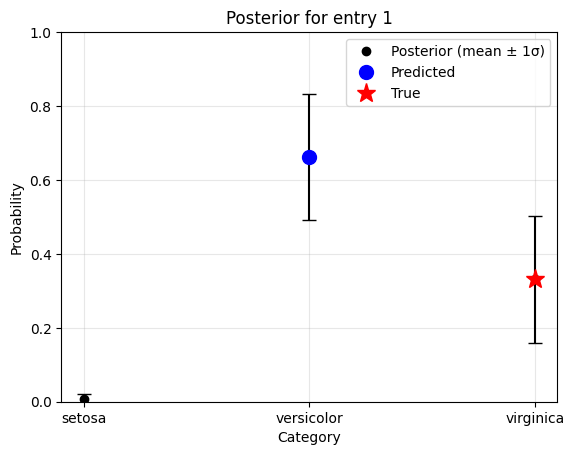

Event 1, true label = versicolor


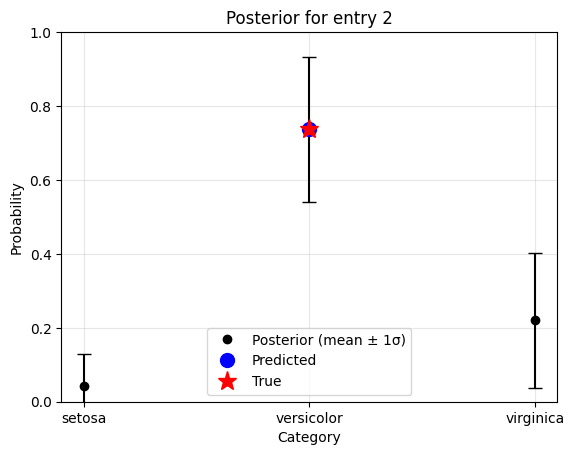

Event 2, true label = setosa


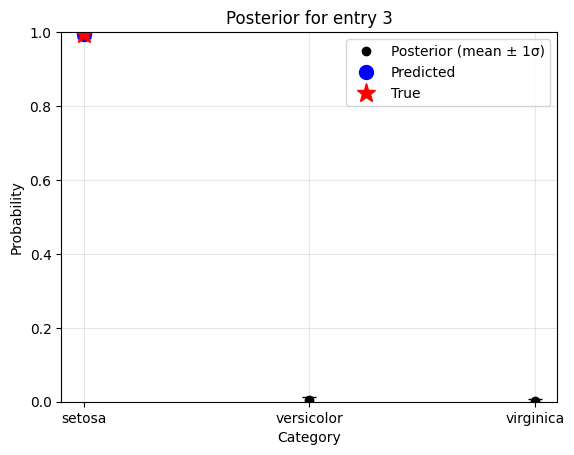

Event 3, true label = versicolor


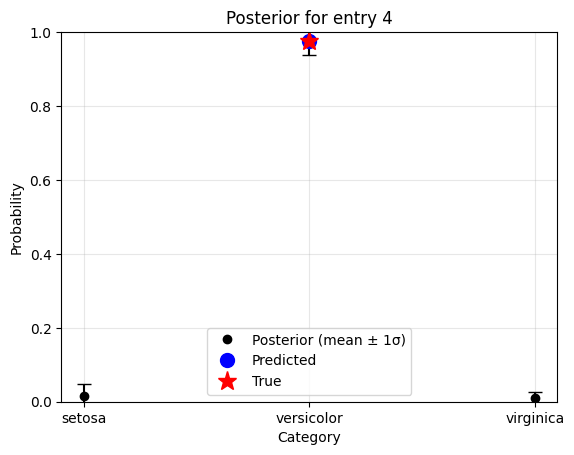

Event 4, true label = virginica


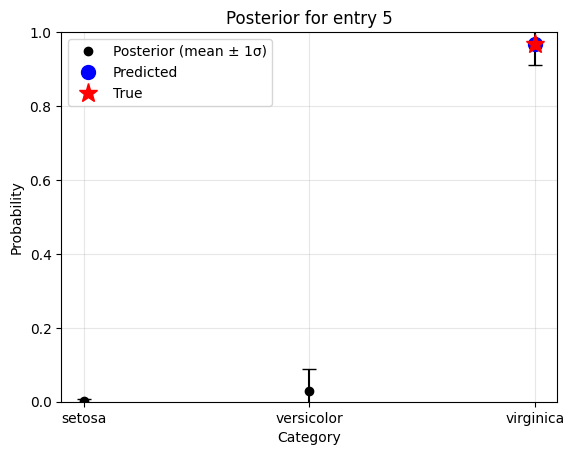

In [48]:
# -------- EXAMPLES --------

# Classify a few
for i in [0, 1, 2, 3, 4]:
    print(f"Event {i}, true label = {iris.target_names[y_test[i]]}")
    classify_with_uncertainty_sigma(posterior,
                                    X_test[i],
                                    y_true=y_test[i],
                                    entry_id=i+1,
                                    class_names=iris.target_names)